# How to Create A Lambda Function for Semantic Segmenation in AWS Panorama


## What this notebook accomplishes

- How to create and deploy a lambda function that is used for a semantic segmentation application using the AWS Panorama service. 
- You will learn the parts of an Panorama application and what they are used for. 
- Then you will put it all together to simulate a semantic segmentation application within the environment of this notebook. 

The application uses a pretrained semantic segmentation model from GluonCV/MXNET. You can find more information and tutorials for semantic segmentation using [MXNET & GluonCV](https://gluon-cv.mxnet.io/build/examples_segmentation/index.html) tools. 

## Requirements

This notebook requires the following packages
- mxnet >= 1.6.0
- gluoncv >= 0.6.0
- opencv-python == 4.4.0
- matplotlib
- boto3

**Pre -Requisites**:
* Sagemaker Instance created with the right role (Policies needed IOT, Lambda and S3, IAM Full Access) ( Add Doc here)


**Frames to Process**:

* By default, we only process 10 frames from the video. If you want to increase this, please change this value in /panorama_sdk/panoramasdk.py and change frames_to_process = 10 to a value of your choice

# Getting Started

## 1. What is Semantic Segmenation

- Instance segmentation is task of detecting objects in an image and segmenting the . 
- This type of deep learning task is used in autonomous driving, medical imaging analysis and terrain classification in sattelite images.
- In other examples, customer's may use this to detect the presence of smoke or clouds in their environments.

## 1.1 The end to end process for Semantic Segmentation inference is relatively simple. 
- It consists of taking an image (or in this case a video frame) and preprocessing it
- performing model inference
- then using the output masks to either visualize or perform further analysis

#### 1.2 Run the next cell to define the preprocessing functions. 
As you can see, these functions just resize the image and normalize the values. 

#### Video to Use

In [2]:
video_to_use = "man_and_tree.mp4"

In [3]:
import os
import sys
path = os.path.abspath(os.path.join(os.path.dirname("panorama_sdk"), '../..'))
sys.path.insert(1, path + '/panorama_sdk')

import panoramasdk
import jupyter_utils
import numpy as np
import cv2
import json

from IPython.display import clear_output, Markdown, display

from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (20,20)

In [4]:
import sagemaker
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

In [5]:
def plot_mask(img, predict, alpha=0.5):
    classes = np.unique(predict)
    w, h, _ = img.shape
    for i, cla in enumerate(classes):
        color = np.random.random(3) * 255
        mask = np.repeat((predict == cla)[:, :, np.newaxis], repeats=3, axis=2).astype(
            "uint8"
        )
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        mask = mask * 255
        mask = cv2.resize(mask, (h, w))
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        img = cv2.drawContours(img, contours, -1, color, -1)
    return img



def normalize(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):

    img = img.astype(np.float32) / 255.0  # converting array of ints to floats
    img_a = img[:, :, 0]
    img_b = img[:, :, 1]
    img_c = img[:, :, 2]

    # Extracting single channels from 3 channel image
    # The above code could also be replaced with cv2.split(img) << which will return 3 numpy arrays (using opencv)

    # normalizing per channel data:
    img_a = (img_a - mean[0]) / std[0]
    img_b = (img_b - mean[1]) / std[1]
    img_c = (img_c - mean[2]) / std[2]

    # putting the 3 channels back together:
    x1 = [[[], [], []]]
    x1[0][0] = img_a
    x1[0][1] = img_b
    x1[0][2] = img_c

    # x1 = mx.nd.array(np.asarray(x1))
    x1 = np.asarray(x1)

    return x1

def preprocess(img, shape=(512, 512)):

    resized = cv2.resize(img, shape)  # (h, w)
    x1 = normalize(resized)
    return x1, resized

#### 1.3 Next, read in the image and transform it. 

In [6]:
filename = "persons.jpg"
img = cv2.imread(filename)            

            
#x1 = self.preprocess(person_image)
print("Processing Image...")
x1, orig_img = preprocess(img, (400, 500))
print("Processed Image")

Processing Image...
Processed Image


#### 1.4 Load the model and perform inference

In [7]:
model = panoramasdk.model()
model.open('fcn_resnet101_voc', 1)


# Create input and output arrays.
mask_info = model.get_output(0)
prob_info = model.get_output(1)

mask_array = np.empty(mask_info.get_dims(), dtype=mask_info.get_type())
prob_array = np.empty(prob_info.get_dims(), dtype=prob_info.get_type())

#### 1.5 Run the next cell to define the mask plotting function

In [8]:
# Do inference on the new frame.
print("Performing Detector Inference")
model.batch(0, x1)
model.flush()
print("Inference Completed.")

# Get the results.
resultBatchSet = model.get_result()

mask_batch = resultBatchSet.get(0)
prob_batch = resultBatchSet.get(1)

Performing Detector Inference
Inference Completed.


#### 1.6 Plot the mask boundaries in the original image

Output shape: (1, 21, 480, 480)
Processed output shape: (480, 480)


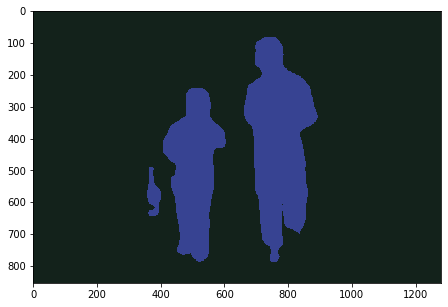

In [9]:
mask_batch.get(0, mask_array)
prob_batch.get(1, prob_array)

masks = mask_array
print("Output shape:", masks.shape)
masks = np.squeeze(np.argmax(masks, 1))
print("Processed output shape:", masks.shape)


image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
image = plot_mask(image, masks)
plt.figure(figsize=(10, 5))
plt.imshow(image)

In the Panorama application, it might be more useful to show boundaries around the pixels instead of the silloutes. This can be done by modifying the following line from the `plot_mask` function.

```
...
img = cv2.drawContours(img, contours, -1, color, 10)
...
```

This is how you will implement the plotting function in the Panorama application later on

## 2. Building the lambda

The first step to building the Panorama application code that goes inside the lambda function is understanding what parts of **Panorama Application Class** are necessary. Panorama service uses objects of this class to manage the model, preprocess images and perform inference.

- At a high level, the raw code cell below is what the application class looks like. 
- The `interface`, `init`, and `entry` methods are the basic necessary components to building the application class.

**Note**: In addition to these methods, you can add custom methods either to the class or the script globally. You will see both illustrated in the final lambda function.

```
class people_mask(panoramasdk.base):
    def interface(self):
        # defines the parameters that interface with other services from Panorama
        
    def init(self, parameters, inputs, outputs):
        # defines the attributes such as arrays and model objects that will be used in the application
        
    def entry(self, inputs, outputs):
        # defines the application logic responsible for predicting using the inputs and handles what to do 
        # with the outputs
```

### 2.1 Defining the `interface` method
The first method to define is the `interface` method. This is an important part of the Panorama application because this is how the application interacts with the resources from the Panorama service. When creating an Panorama Application in the Panorama console, you should have specified the model that will be used for predicting, the IP camera input streams and where the application's output is going. 
- The Panorama Service compiles your pretrained model and prepares it to be deployed to Manhattan device. 
- Camera inputs are defined so that each camera's stream images are passed to the application to be predicted on by the AWS Lambda function's application code.
- Outputs are defined to receive the model's post-processed output. This is usually set to output to HDMI for visualizing results.

Lastly, the interface method then defines these inputs and outputs within the Panorama application class so that the application has access to them in the `entry` function. 

```
def interface(self):
    return {
        "parameters":
            (
                ("model", "segmodel", "Model for segmenting pixels", "segmentation-model2"),
                ("int", "batch_size", "Model batch size", 1),
            ),
        "inputs":
            (
                ("media[]", "video_in", "Camera input stream"),
            ),
        "outputs":
            (
                ("media[video_in]", "video_out", "Camera output stream"),
            )
    }
```

The `interface` method returns a dictionary of items that define parameters, inputs and outputs. 
- These items consist of an array of tuples. 
- Each tuple follows this schema:

(`data type`, `variable name`, `description`, `value`)

**Tip**: You can add your own parameters to the `parameters` object, that can be later used in the `init` method. 

For this example, you will set the value of the `segmodel` parameter to **"segmentation-model"**, and in the future you will set it to the name of the model you have defined to be part of the Panorama application in the Panorama Console. Batch size will always be 1. 

### 2.2 Defining the `init` method

The init method serves a similar purpose to traditional `__init__` methods used in python classes. 
- The difference here is that the initialization parameters come from the `parameters` object passed. 
- Using this `parameters` object, you can initialize the model that has been previously uploaded in the Panorama Console. 
- You will also define array containers for the model's output based on the model's output shapes.

```
def init(self, parameters, inputs, outputs):
    try:
        self.frame_num = 0

        # Load model from the specified directory.
        print("loading the model...")
        self.model = panoramasdk.model()
        self.model.open(parameters.segmodel, 1)
        print("model loaded")

        # Create input and output arrays.
        mask_info = self.model.get_output(0)
        prob_info = self.model.get_output(1)

        self.mask_array = np.empty(mask_info.get_dims(), dtype=mask_info.get_type())
        self.prob_array = np.empty(prob_info.get_dims(), dtype=prob_info.get_type())

        return True

    except Exception as e:
        print("Exception: {}".format(e))
        return False
```

One thing to note, with the code below
```
...
self.model = panoramasdk.model()
self.model.open(parameters.segmodel, 1)
...
```
First, an `panoramasdk.model` object is initialized, then the pretrained model is loaded into that object. 
- It knows what model to load based on the parameter you set in `interface` for the corrresponding model parameter. 
- In this notebook you will use a different pattern so that it can demo-ed in a notebook environment, but it will behave similarly. 

### 2.3 Defining the `entry` method

The entry method is the *entry* point for the Panorama application; and it contains all the logic to perform for each video input, for each frame. This is where you will perform the preprocessing, inferencing, and post-processing. 
For the segmentation task, it's as simple as the following steps:

1. preprocess the image input
2. perform inference
3. get the results
4. plot the masks received from the results

```
def entry(self, inputs, outputs):

    for i in range(len(inputs.video_in)):

        stream = inputs.video_in[i]

        person_image = stream.image

        #x1 = self.preprocess(person_image)
        print("Processing Image...")
        x1, orig_img = preprocess(person_image, (400, 500))
        print("Processed Image")


        # Do inference on the new frame.
        print("Performing Detector Inference")
        self.model.batch(0, x1)
        self.model.flush()
        print("Inference Completed.")

        # Get the results.
        resultBatchSet = self.model.get_result()

        mask_batch = resultBatchSet.get(0)
        prob_batch = resultBatchSet.get(1)

        mask_batch.get(0, self.mask_array)
        prob_batch.get(0, self.prob_array)

        masks = np.squeeze(np.argmax(self.mask_array, 1))
        _ = plot_mask(stream.image, masks)


        self.model.release_result(resultBatchSet)
        outputs.video_out[i] = stream

    return True
```

## 3. Putting it all together

A version of the lambda code compatible within a notebook environment has been written for you below. Run the next cell to visualize the application's output. 

**Note**: Custom functions are defined globablly, outside of the class. You could also defined the same custom functions as part of the `segmentation` class.

In [10]:
jupyter_utils.change_video_source(video_to_use)

Video Changed to man_and_tree.mp4


In [11]:
import panoramasdk
import cv2
import numpy as np
import boto3



def plot_mask(img, predict, alpha=0.5):
    classes = np.unique(predict)
    w, h, _ = img.shape
    for i, cla in enumerate(classes):
        color = np.random.random(3) * 255
        mask = np.repeat((predict == cla)[:, :, np.newaxis], repeats=3, axis=2).astype(
            "uint8"
        )
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        mask = mask * 255
        mask = cv2.resize(mask, (h, w))
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        img = cv2.drawContours(img, contours, -1, color, -1)
    return img
    
def preprocess(img, shape=(512, 512)):
    
    resized = cv2.resize(img, shape) # (h, w)
    x1 = normalize(resized)
    return x1, resized
        
def normalize(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):

    img = img.astype(np.float32) / 255.  # converting array of ints to floats
    img_a = img[:, :, 0]
    img_b = img[:, :, 1]
    img_c = img[:, :, 2]

    # Extracting single channels from 3 channel image
    # The above code could also be replaced with cv2.split(img) << which will return 3 numpy arrays (using opencv)

    # normalizing per channel data:
    img_a = (img_a - mean[0]) / std[0]
    img_b = (img_b - mean[1]) / std[1]
    img_c = (img_c - mean[2]) / std[2]

    # putting the 3 channels back together:
    x1 = [[[], [], []]]
    x1[0][0] = img_a
    x1[0][1] = img_b
    x1[0][2] = img_c

    # x1 = mx.nd.array(np.asarray(x1))
    x1 = np.asarray(x1)
    
    return x1    

class segmentation(panoramasdk.base):
    
    def interface(self):
        return {
            "parameters":
                (
                    ("model", "segmodel", "Model for people detecting", "fcn_resnet101_voc"),
                    ("int", "batch_size", "Model batch size", 1),
                ),
            "inputs":
                (
                    ("media[]", "video_in", "Camera input stream"),
                ),
            "outputs":
                (
                    ("media[video_in]", "video_out", "Camera output stream"),
                )
        }


    def init(self, parameters, inputs, outputs):
        try:
            self.frame_num = 0
            
            # Load model from the specified directory.
            print("loading the model...")
            self.model = panoramasdk.model()
            self.model.open(parameters.segmodel, 1)
            print("model loaded")
            
            # Create input and output arrays.
            mask_info = self.model.get_output(0)
            prob_info = self.model.get_output(1)
        
            self.mask_array = np.empty(mask_info.get_dims(), dtype=mask_info.get_type())
            self.prob_array = np.empty(prob_info.get_dims(), dtype=prob_info.get_type())
            
            return True

        except Exception as e:
            print("Exception: {}".format(e))
            return False
        
    def entry(self, inputs, outputs):

        for i in range(len(inputs.video_in)):

            stream = inputs.video_in[i]
            person_image = stream.image
            
            
            #print("Processing Image...")
            x1, orig_img = preprocess(person_image, (400, 500))
            #print("Processed Image")
            
            
            # Do inference on the new frame.
            #print("Performing Detector Inference")
            self.model.batch(0, x1)
            self.model.flush()
            #print("Inference Completed.")

            # Get the results.
            resultBatchSet = self.model.get_result()

            mask_batch = resultBatchSet.get(0)
            prob_batch = resultBatchSet.get(1)
            
            mask_batch.get(0, self.mask_array)
            prob_batch.get(0, self.prob_array)
        
            masks = np.squeeze(np.argmax(self.mask_array, 1))
            
            person_image = plot_mask(person_image, masks)
        
        
            self.model.release_result(resultBatchSet)
            outputs.video_out[i] = stream
            
            

        return True




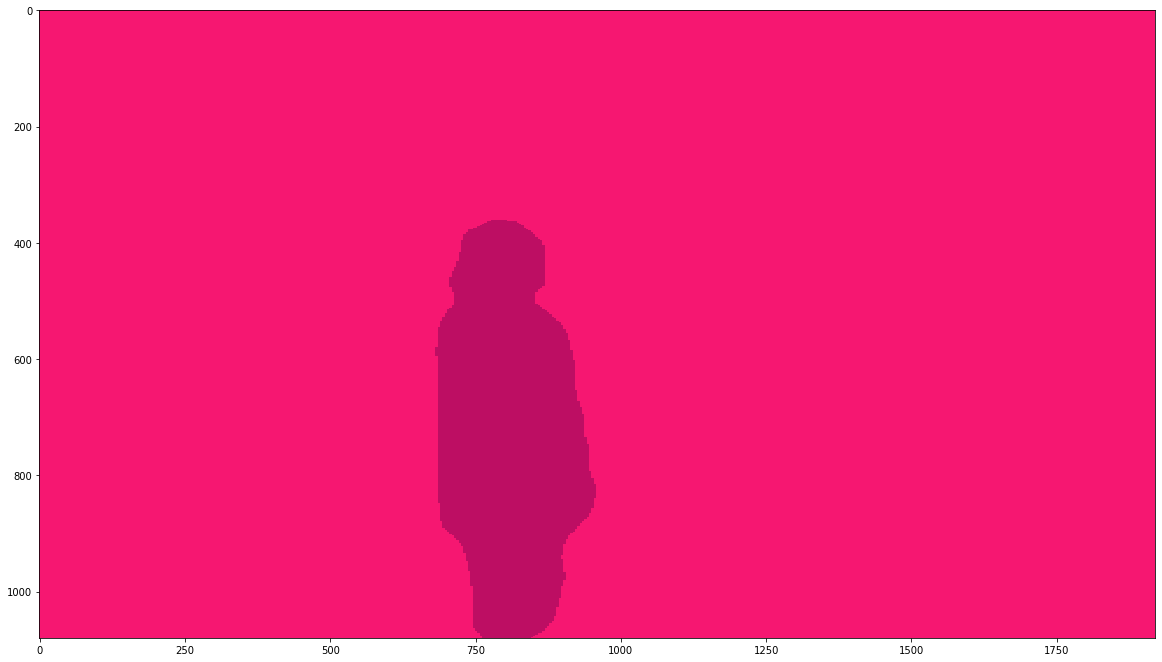

In [12]:
def main():
    segmentation().run()
    
main()

## 4. Deploying Lambda

As mentioned previously, code from above is adapted to run within a notebook environment. You can find the actual lambda code in `segmentation.py` found in the **Lambda** directory. In order to deploy a lambda function from this notebook, you will need the `semantic-segmentation.zip` file that contains the following files:
- segmentation.py

### 4.1 Define boto sessions
Run the following cell to initialize boto3 to interface with AWS Lambda service

### 4.2 Create the role for Lambda Execution
Running the next cell will create an execution role that will be used to deploy your lambda zip file.

In [14]:
role_policy_document = {
    "Version": "2012-10-17",
    "Statement":[
        {
            "Effect": "Allow",
            "Principal": {"Service": ["lambda.amazonaws.com", "events.amazonaws.com"]},
            "Action": "sts:AssumeRole",
        }
    ]
}

iam_client = boto3.client("iam")

iam_client.create_role(
    RoleName="SemanticSegExecutionRole",
    AssumeRolePolicyDocument=json.dumps(role_policy_document),
)

{'Role': {'Path': '/',
  'RoleName': 'SemanticSegExecutionRole1',
  'RoleId': 'AROAZAPJMVFPIORHMCOUW',
  'Arn': 'arn:aws:iam::619501627742:role/SemanticSegExecutionRole1',
  'CreateDate': datetime.datetime(2020, 11, 19, 20, 6, tzinfo=tzlocal()),
  'AssumeRolePolicyDocument': {'Version': '2012-10-17',
   'Statement': [{'Effect': 'Allow',
     'Principal': {'Service': ['lambda.amazonaws.com',
       'events.amazonaws.com']},
     'Action': 'sts:AssumeRole'}]}},
 'ResponseMetadata': {'RequestId': '585fecae-4851-414a-8243-e8371f4e6266',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '585fecae-4851-414a-8243-e8371f4e6266',
   'content-type': 'text/xml',
   'content-length': '842',
   'date': 'Thu, 19 Nov 2020 20:06:00 GMT'},
  'RetryAttempts': 0}}

### 4.3 Create the AWS Lambda function
Next, the following cell creates the lambda function in your AWS Lambda service and uploads your zip file. 

In [16]:
!zip -o  ../Lambda/segmentation.zip  ../Lambda/segmentation.py

  adding: ../Lambda/segmentation.py (deflated 64%)


In [18]:
# Create Lambda client
lambda_client = boto3.client('lambda')

with open('../Lambda/segmentation.zip', 'rb') as f:
    zipped_code = f.read()

role = iam_client.get_role(RoleName='SemanticSegExecutionRole')
response_create_function = lambda_client.create_function(
  FunctionName='SegmentationSegmentationLambda',
  Runtime='python3.7',
  Role=role['Role']['Arn'],
  Handler='segmentation.main',
    Code=dict(ZipFile=zipped_code),
    Timeout=120,
    MemorySize=2048,
)

**What is an ARN?** : Amazon Resource Names (ARNs) uniquely identify AWS resources.

The following Python snippet will publish the Lambda Function we created above, and return an ARN with a version. 

This version arn can be used to go directly to the Panorama console and deploy this application.

### 4.4 Publish Lambda
Lastly, publish the latest version of you lambda function so that it's available to use in the Panorama Application console. 

In [22]:
def printmd(string, color=None):
    """
    Helper Function for Fomatting Output
    """
    colorstr = "<span style='color:{}'>{}</span>".format(color, string)
    display(Markdown(colorstr))
    

In [20]:
# Publish Lambda
response = lambda_client.publish_version(
      FunctionName='SegmentationSegmentationLambda'
  )

Printing the details of the lambda function that was just published

In [25]:
function_arn = response["FunctionArn"]
function_arn_version = list(response["FunctionArn"].split(":"))[-1]
lambda_url = (
    "https://console.aws.amazon.com/lambda/home?region=us-east-1#/functions/"
    + response["FunctionName"]
    + "/versions/"
    + response["Version"]
    + "?tab=configuration"
)

printmd("**Function Arn** : **{}**".format(function_arn), color="black")
printmd("**Function Arn Version** : **{}**".format(function_arn_version), color="black")
printmd("**Lambda Console Link** : **{}**".format(lambda_url), color="black")

<span style='color:black'>**Function Arn** : **arn:aws:lambda:us-east-1:619501627742:function:SegmentationSegmentationLambda:1**</span>

<span style='color:black'>**Function Arn Version** : **1**</span>

<span style='color:black'>**Lambda Console Link** : **https://console.aws.amazon.com/lambda/home?region=us-east-1#/functions/SegmentationSegmentationLambda/versions/1?tab=configuration**</span>

### 4.4 : Upload Model to S3 Bucket

In [24]:
def send_model_to_s3(model, bucket = 'aws-panorama-models-bucket'):
    s3 = boto3.resource('s3')
    s3.create_bucket(Bucket=bucket)
    
    key = '../../Models/' + model
    
    s3.Object(bucket, model).put(Body=open(key, 'rb'))
    
    bucket_name = bucket
    
    
    location = boto3.client('s3').get_bucket_location(Bucket='aws-panorama-models-bucket')['LocationConstraint']
    url = "s3://{}/{}".format(bucket_name, model)
    
    printmd("**S3 Path** : **{}**".format(url), color="black")
    
    return


In [25]:
send_model_to_s3(model = 'fcn_resnet101_voc.tar.gz')

<span style='color:black'>**S3 Path** : **s3://aws-panorama-models-bucket/fcn_resnet101_voc.tar.gz**</span>

### 5 : Deploy the Application

The Lambda is now created and published. You are now ready to deploy your model and the published lambda function, to the Panorama device

The instructions to deploy are linked below

[Creating Application Instructions Here](https://docs.aws.amazon.com/panorama/)